# Data Scientist Challenge

## Goal
As a TRI-AD data scientist you will need to have strong analytical skills as well as
experience building software and strong communication skills. This technical
challenge will cover all three of these components using a sample data set.
You will be provided with a data set about students. The data set includes
information about the students’ age, nationality, gender, as well as information
about their studying habits. There is also a binary column expressing whether or not
the students passed an important test.

## Part 1: Analysis
- Describe the demographic details of people most likely to pass the test
- Describe the efficacy of the two interventions - the test prep course and the
Dojo class
- Identify any other interesting trends from the data set and offer some analysis
as to their importance or cause.

## Part 2: Model Creation
Create a model that can predict whether or not a student will pass the test. Use the
provided data set to train your model and test its accuracy. You have free choice of
programming language, algorithm, and tools.


## Part 3: Reporting
The goal in the final stage is to communicate your findings to less technical
management staff. There are two requirements:
- Create visualizations to show the efficacy of your model. A non-data scientist
should be able to infer at a glance how well it fits the data.
- Offer ideas for how we might help more people pass the test and create more
accurate models based on your findings. Summarize with bullet points and
consider adding more visuals.

---

# Phase 1: Data Import and Analyses

## Import the data from the database

* Use DBeaver or any other suitable tool to connect to the database and retrieve the data from the 'heart' schema.
* Consider using SQL queries to join relevant tables if necessary.

In [1]:
import os

# from dotenv import load_dotenv
# from sqlalchemy import create_engine
from scipy import stats

import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# from autofeatselect import CorrelationCalculator, FeatureSelector, AutoFeatureSelect


from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    classification_report,
)

# models
from xgboost import XGBClassifier

# Define a plotting style to be used for all plots in this notebook
plt.style.use("tableau-colorblind10")

In [2]:
"""# Read database string from .env file (no need to change anything)
load_dotenv()

DB_STRING = os.getenv("DB_STRING")

db = create_engine(DB_STRING)"""

'# Read database string from .env file (no need to change anything)\nload_dotenv()\n\nDB_STRING = os.getenv("DB_STRING")\n\ndb = create_engine(DB_STRING)'

In [3]:
# Define query to download data (add your query here)
query_string = """SET SCHEMA 'takemehome'; SELECT * FROM triad t;"""

## 2. Conduct a brief EDA (Exploratory Data Analysis):

* Load the data into a Pandas DataFrame or your preferred data manipulation tool.

In [ ]:
# df = pd.read_sql(query_string, db)
# df.to_csv("./data/triad.csv", index=False)

In [4]:
# load data
df = pd.read_csv("./data/triad.csv")

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   sex            5000 non-null   object 
 1   lang           5000 non-null   object 
 2   country        5000 non-null   object 
 3   age            5000 non-null   int64  
 4   hours_studied  3018 non-null   float64
 5   dojo_class     5000 non-null   bool   
 6   test_prep      5000 non-null   bool   
 7   pass           5000 non-null   bool   
 8   notes          772 non-null    object 
dtypes: bool(3), float64(1), int64(1), object(4)
memory usage: 249.2+ KB


In [6]:
df

,sex,lang,country,age,hours_studied,dojo_class,test_prep,pass,notes
0,Male,Japanese,Japan,20,10.578594,True,False,True,NaN
1,Male,Japanese,Japan,22,7.814520,False,False,True,NaN
2,Male,Japanese,Japan,27,4.213682,False,False,True,NaN
3,Male,Japanese,Japan,24,NaN,False,False,True,NaN
4,Female,Japanese,Japan,21,3.248907,False,False,False,NaN
...,...,...,...,...,...,...,...,...,...
4995,Male,Japanese,Japan,29,3.291721,False,False,True,NaN
4996,Female,Japanese,Japan,22,1.590491,False,False,False,NaN
4997,Male,English,UK,25,5.029988,False,False,False,NaN
4998,Male,Japanese,Japan,22,1.730570,True,False,True,NaN


In [7]:
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
sex,5000,2,Male,3719,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lang,5000,6,Japanese,4022,NaN,NaN,NaN,NaN,NaN,NaN,NaN
country,5000,10,Japan,4022,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,5000.0,NaN,NaN,NaN,25.8734,7.349978,18.0,20.0,24.0,30.0,50.0
hours_studied,3018.0,NaN,NaN,NaN,4.964076,3.203037,0.139203,2.555823,4.247235,6.660737,24.259314
dojo_class,5000,2,False,3518,NaN,NaN,NaN,NaN,NaN,NaN,NaN
test_prep,5000,2,False,3986,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pass,5000,2,False,2665,NaN,NaN,NaN,NaN,NaN,NaN,NaN
notes,772,393,CON,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# drop notes because it is not useful for the analysis, looks like radom generated data

df = df.drop("notes", axis=1)

0.3964

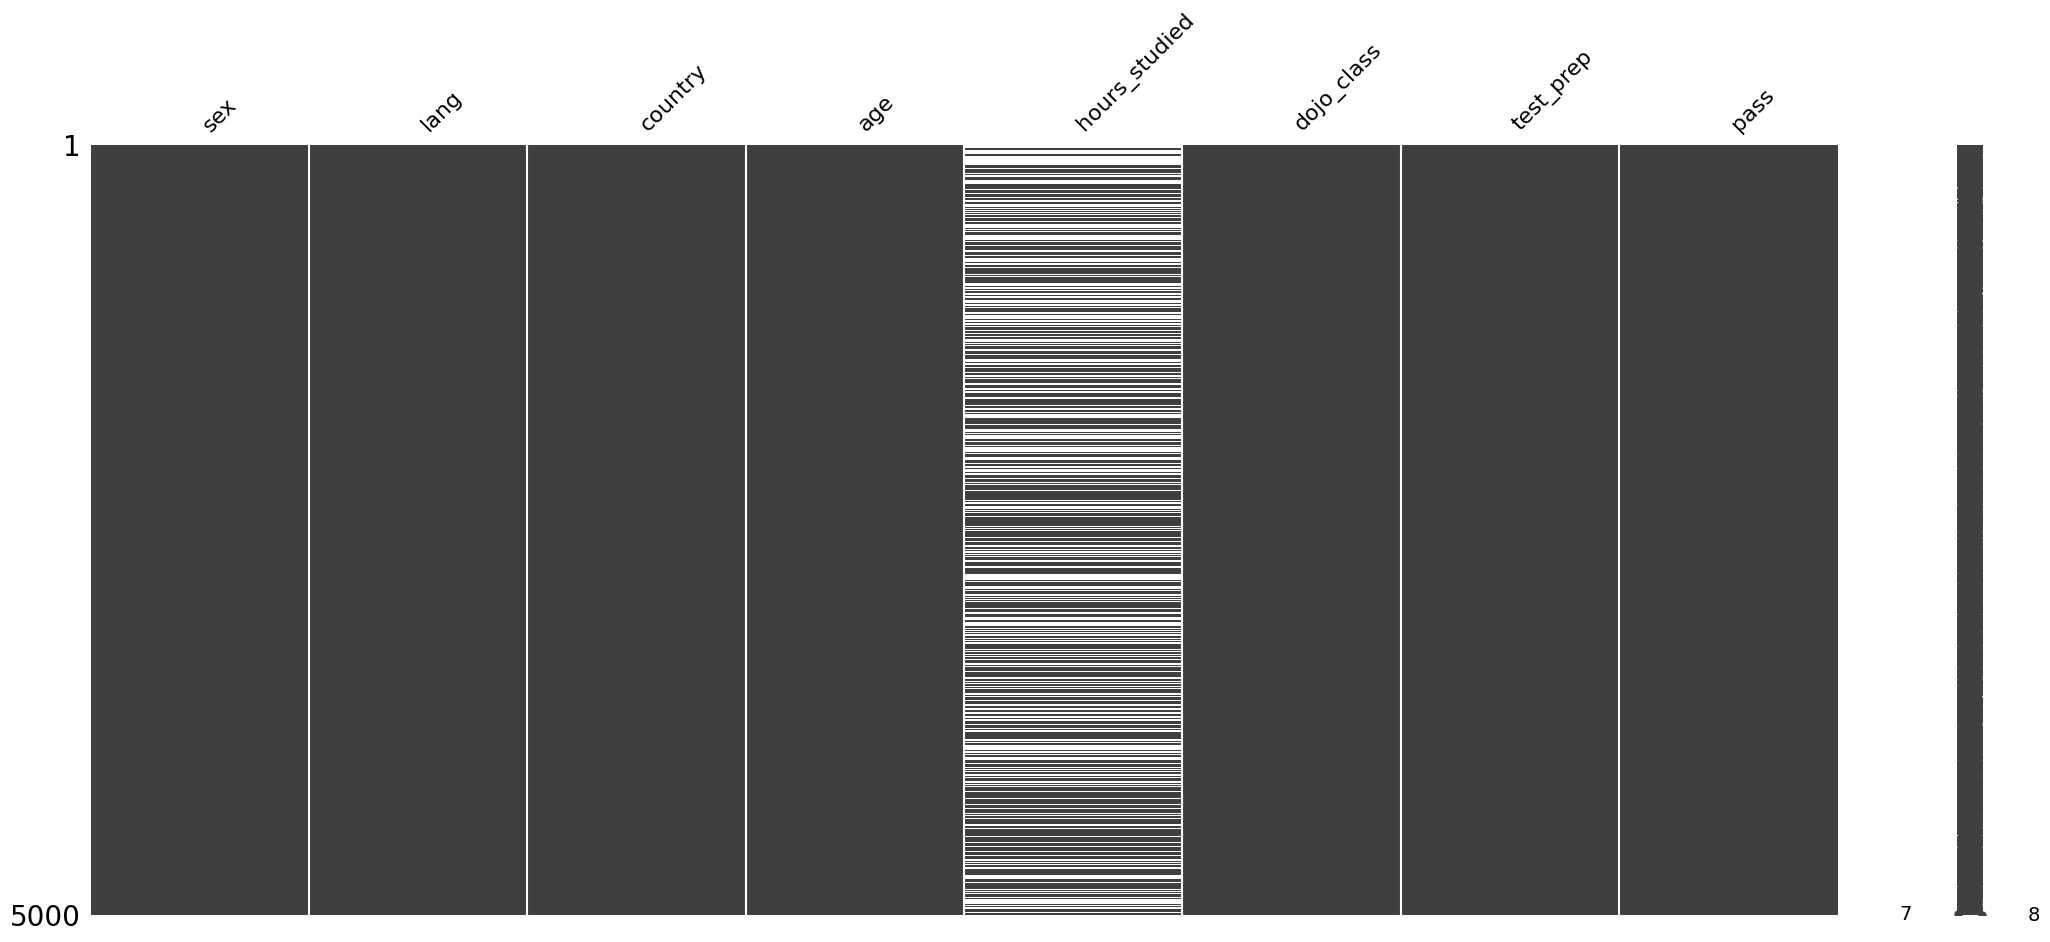

In [13]:
# check for missing values
msno.matrix(df)

# hours studied has a lot of missing values, let's check how many
df["hours_studied"].isna().sum() / len(df)

# almost 40% of the data is missing, but I would still keep it because it is an important feature

In [14]:
# create bins for age, to compare the age groups for the target variable and other features

bins = [18, 25, 30, 35, 40, 45, 50]
labels = ["18-25", "25-30", "30-35", "35-40", "40-45", "45-50"]

df["age_bin"] = pd.cut(df["age"], bins=bins, labels=labels)

print(df[["age", "age_bin"]].head())

   age age_bin
0   20   18-25
1   22   18-25
2   27   25-30
3   24   18-25
4   21   18-25


In [15]:
df

,sex,lang,country,age,hours_studied,dojo_class,test_prep,pass,age_bin
0,Male,Japanese,Japan,20,10.578594,True,False,True,18-25
1,Male,Japanese,Japan,22,7.814520,False,False,True,18-25
2,Male,Japanese,Japan,27,4.213682,False,False,True,25-30
3,Male,Japanese,Japan,24,NaN,False,False,True,18-25
4,Female,Japanese,Japan,21,3.248907,False,False,False,18-25
...,...,...,...,...,...,...,...,...,...
4995,Male,Japanese,Japan,29,3.291721,False,False,True,25-30
4996,Female,Japanese,Japan,22,1.590491,False,False,False,18-25
4997,Male,English,UK,25,5.029988,False,False,False,18-25
4998,Male,Japanese,Japan,22,1.730570,True,False,True,18-25


<Axes: xlabel='pass', ylabel='count'>

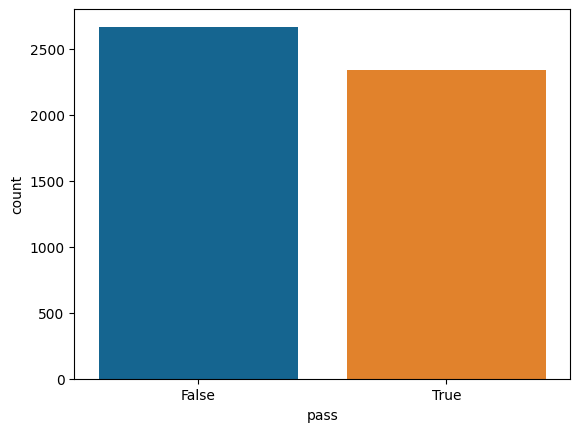

In [19]:
# show the distribution of the target variable
sns.countplot(x="pass", data=df)

# it looks like the data is balanced

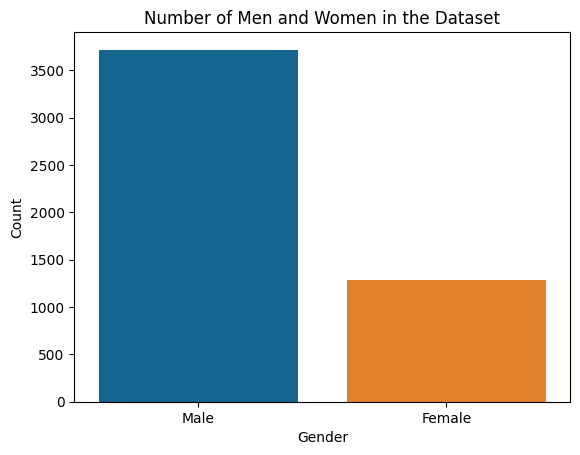

In [67]:
# show how many men and women are in the dataset

gender_counts = df["sex"].value_counts()

# Create a bar plot
sns.barplot(x=gender_counts.index, y=gender_counts.values)

# Add labels and a title
plt.xlabel("Gender")
plt.ylabel("Count")
plt.title("Number of Men and Women in the Dataset")

# Show the plot
plt.show()

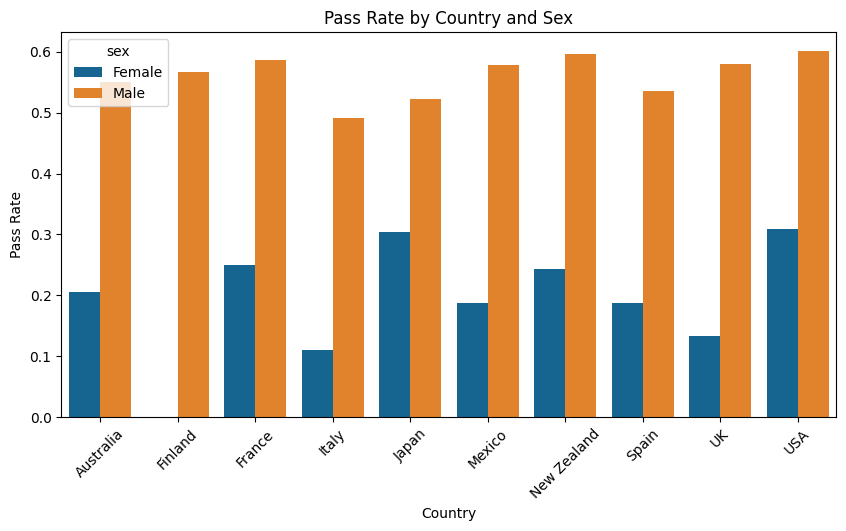

In [20]:
# show the pass rate by country and sex, to get a better feeling for the demographics
# using mean instead of count, better for scaling

pass_rate_country_sex = df.groupby(["country", "sex"])["pass"].mean().reset_index()

plt.figure(figsize=(10, 5))
sns.barplot(data=pass_rate_country_sex, x="country", y="pass", hue="sex")
plt.title("Pass Rate by Country and Sex")
plt.xlabel("Country")
plt.ylabel("Pass Rate")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

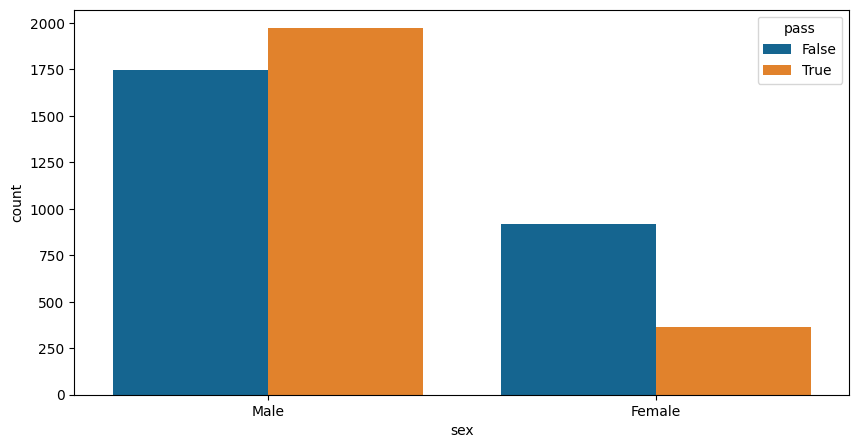

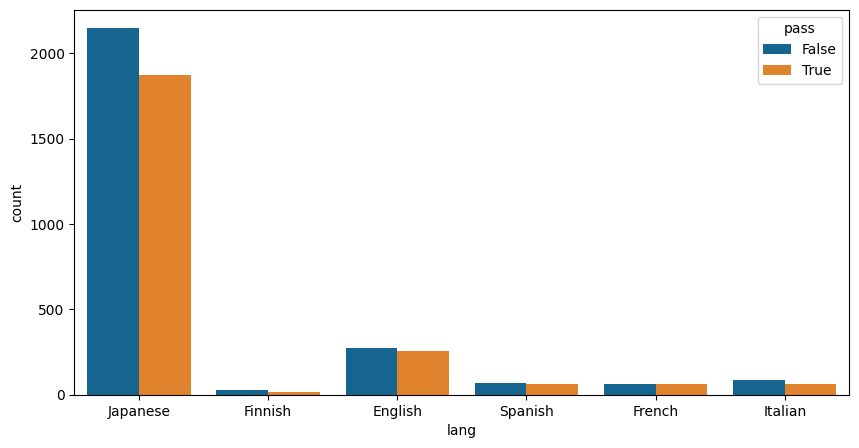

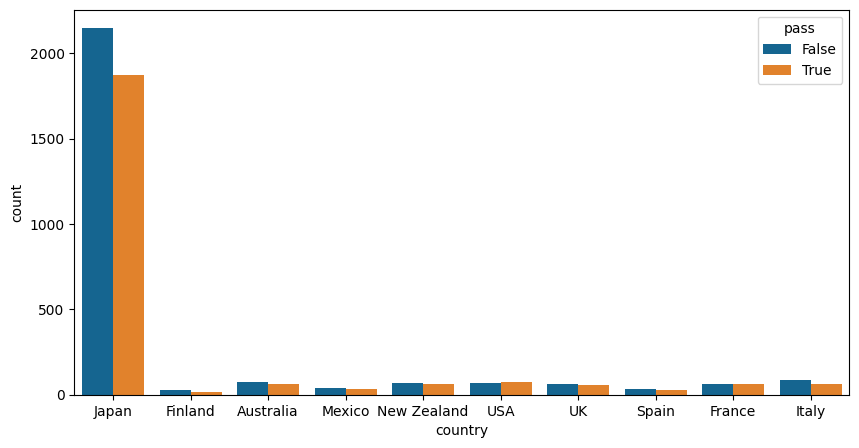

In [23]:
# Distribution Comparison - Catagorical Variables

cat_var = df.select_dtypes(include="object").columns.tolist()

for i in cat_var:
    plt.figure(figsize=(10, 5))
    sns.countplot(data=df, x=i, hue="pass")
    plt.show()

In [30]:
# show data pass rate dirsibution by percentage for each country
df.groupby("country")["pass"].value_counts(normalize=True)

country      pass 
Australia    False    0.537313
             True     0.462687
Finland      False    0.622222
             True     0.377778
France       False    0.507812
             True     0.492188
Italy        False    0.579310
             True     0.420690
Japan        False    0.533814
             True     0.466186
Mexico       False    0.506849
             True     0.493151
New Zealand  False    0.503817
             True     0.496183
Spain        False    0.559322
             True     0.440678
UK           False    0.528455
             True     0.471545
USA          True     0.514286
             False    0.485714
Name: proportion, dtype: float64

In [31]:
# show countries sorted by pass rate
df.groupby("country")["pass"].mean().sort_values(ascending=False)

country
USA            0.514286
New Zealand    0.496183
Mexico         0.493151
France         0.492188
UK             0.471545
Japan          0.466186
Australia      0.462687
Spain          0.440678
Italy          0.420690
Finland        0.377778
Name: pass, dtype: float64

In [27]:
# show country distribution by percentage
df["country"].value_counts(normalize=True)

country
Japan          0.8044
Italy          0.0290
USA            0.0280
Australia      0.0268
New Zealand    0.0262
France         0.0256
UK             0.0246
Mexico         0.0146
Spain          0.0118
Finland        0.0090
Name: proportion, dtype: float64

In [ ]:
### FINDINGS ###

# man have a higher passing rate, because the are more 3x more men in the dataset
# the data is unbalances for the countries, japan has the most data
# the data is unbalanced for sex
# US has the highest passing rate

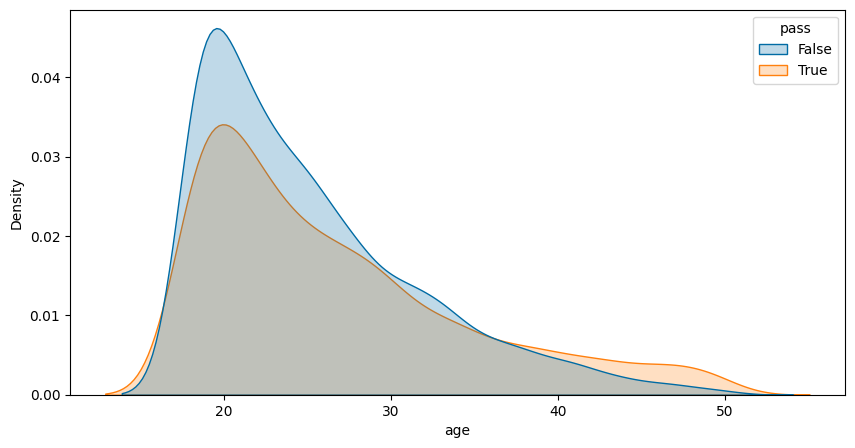

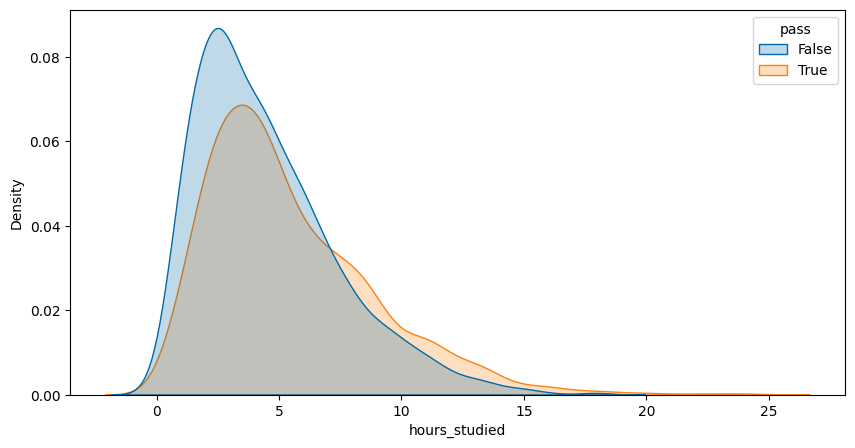

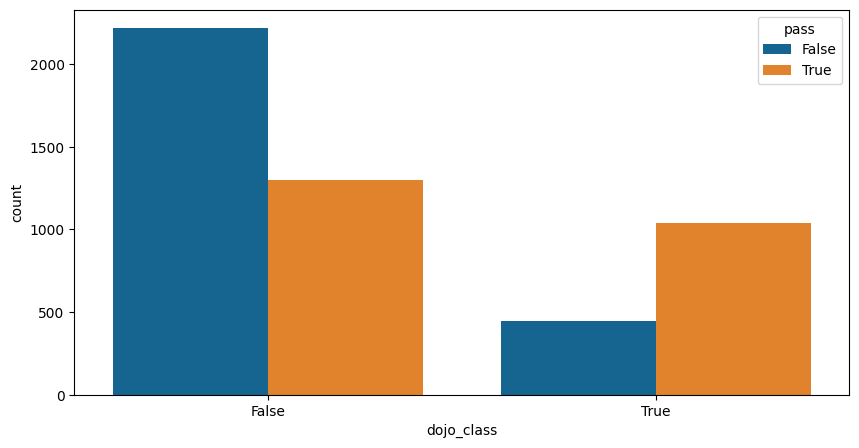

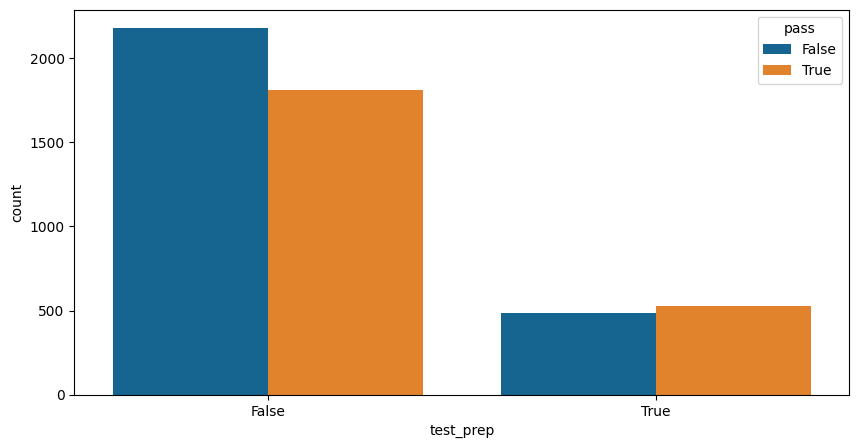

<Figure size 1000x500 with 0 Axes>

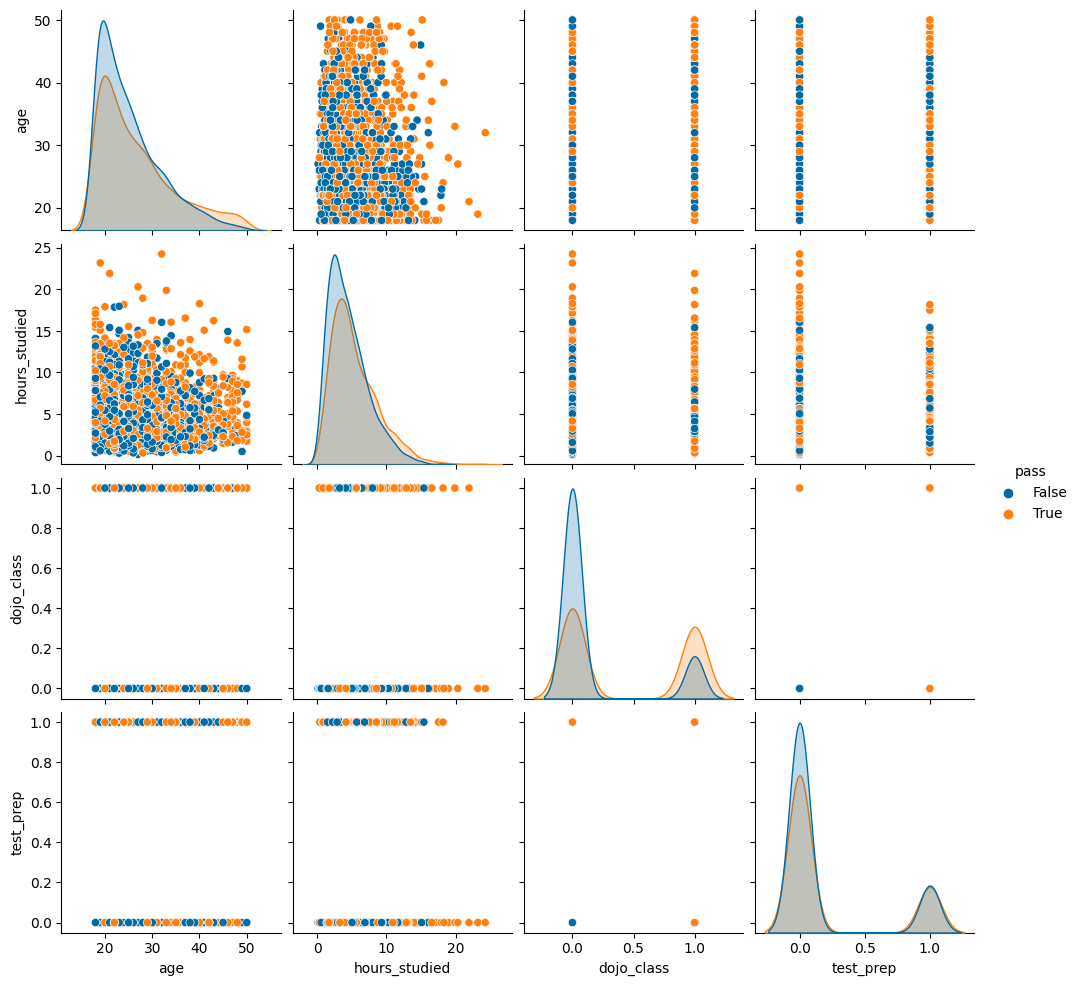

<Figure size 1000x500 with 0 Axes>

In [32]:
# Distribution Comparison - Continuous Variables

con_var = df.select_dtypes(include=["int64", "float64"]).columns.tolist()

for i in con_var:
    plt.figure(figsize=(10, 5))
    sns.kdeplot(data=df, x=i, hue="pass", shade=True)
    plt.show()

# Distribution Comparison - Boolean Variables

bool_var = df.select_dtypes(include="bool").columns.tolist()[:2]

for i in bool_var:
    plt.figure(figsize=(10, 5))
    sns.countplot(data=df, x=i, hue="pass")
    plt.show()

# Show relationships between variables
sns.pairplot(hue="pass", data=df)

# show the pass for every country by sex
plt.figure(figsize=(10, 5))

In [ ]:
### FINDINGS ###

# students that are older then 30 have a higher passing rate
# if you study more then 7.5 hours, you have a higher passing rate
# if you take the dojo_class, you have a higher passing rate
# the test_prep is helping the students to pass the test, with age between 18-35

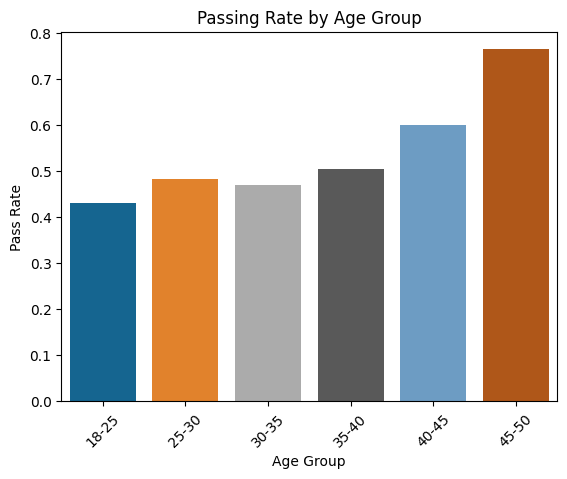

In [33]:
pass_rate_age = df.groupby("age_bin")["pass"].mean().reset_index()
sns.barplot(data=pass_rate_age, x="age_bin", y="pass")
plt.title("Passing Rate by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Pass Rate")
plt.xticks(rotation=45)
plt.show()

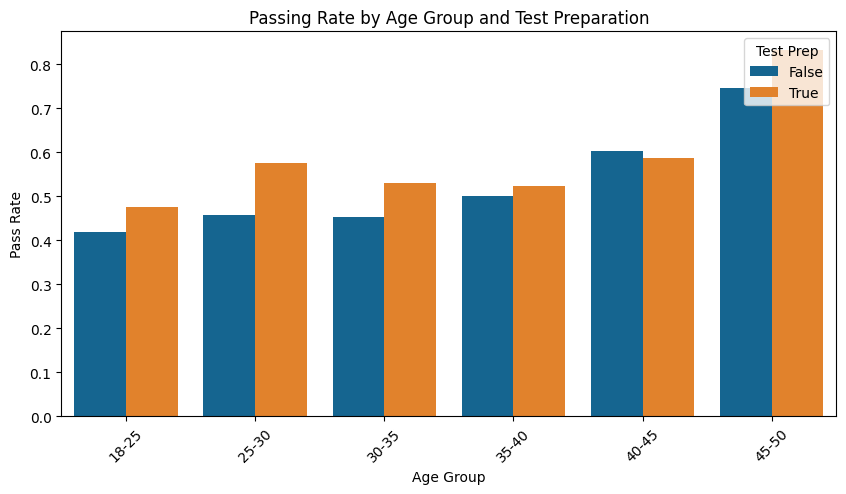

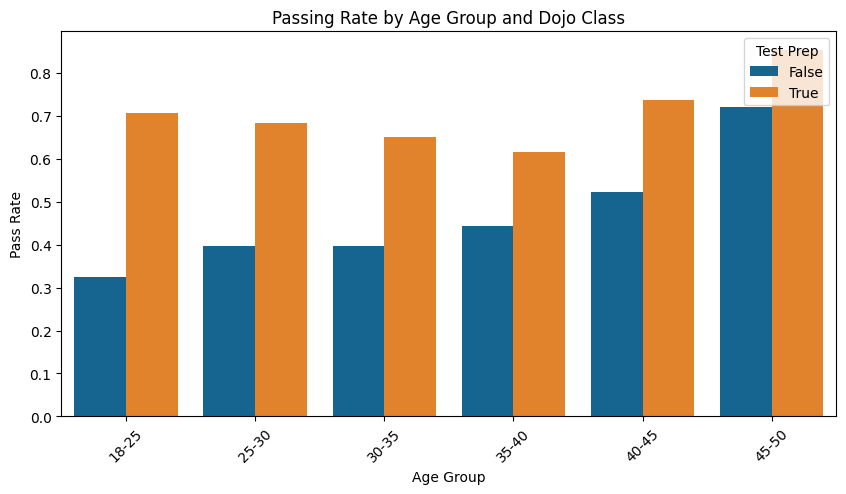

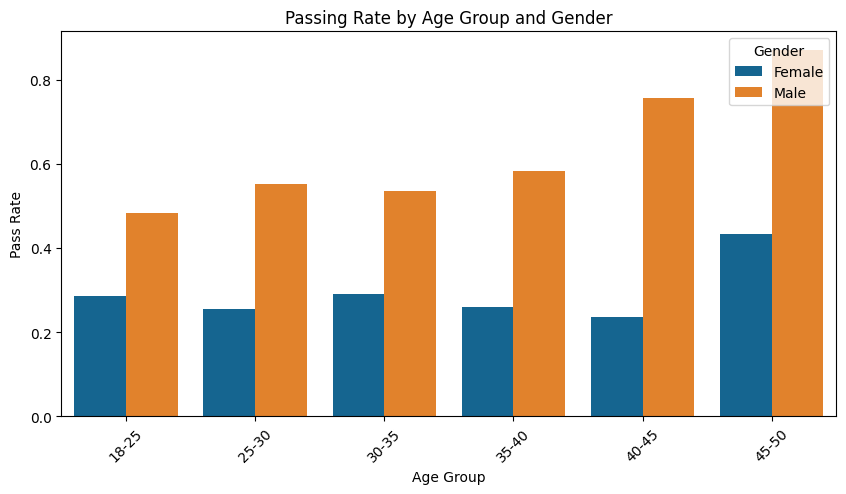

In [34]:
# Passing Rate by Age and Test Preparation

pass_rate_age_prep = df.groupby(["age_bin", "test_prep"])["pass"].mean().reset_index()

plt.figure(figsize=(10, 5))
sns.barplot(data=pass_rate_age_prep, x="age_bin", y="pass", hue="test_prep")
plt.title("Passing Rate by Age Group and Test Preparation")
plt.xlabel("Age Group")
plt.ylabel("Pass Rate")
plt.xticks(rotation=45)
plt.legend(title="Test Prep", loc="upper right")
plt.show()

# Passing Rate by Age and Test Preparation

pass_rate_age_prep = df.groupby(["age_bin", "dojo_class"])["pass"].mean().reset_index()

plt.figure(figsize=(10, 5))
sns.barplot(data=pass_rate_age_prep, x="age_bin", y="pass", hue="dojo_class")
plt.title("Passing Rate by Age Group and Dojo Class")
plt.xlabel("Age Group")
plt.ylabel("Pass Rate")
plt.xticks(rotation=45)
plt.legend(title="Test Prep", loc="upper right")

# Passing Rate by Age and Gender:

pass_rate_age_gender = df.groupby(["age_bin", "sex"])["pass"].mean().reset_index()

plt.figure(figsize=(10, 5))
sns.barplot(data=pass_rate_age_gender, x="age_bin", y="pass", hue="sex")
plt.title("Passing Rate by Age Group and Gender")
plt.xlabel("Age Group")
plt.ylabel("Pass Rate")
plt.xticks(rotation=45)
plt.legend(title="Gender", loc="upper right")
plt.show()

In [ ]:
### FINDINGS ###

# students that are older then 30 have a higher passing rate
# if you study more then 7.5 hours, you have a higher passing rate
# if you take the dojo_class, you have a higher passing rate
# the test_prep is helping the students to pass the test, with age between 18-35
# the data has more men, because most of them are from japan and in japan the men do mostly the money making and get more education

## Part 2: Model Creation

In [ ]:
# do one-hot encoding for categorical variables
# change true and false to 1 and 0
# change sex to 1 and 0
# bin the age variable
# transform the skewed distributions

In [35]:
df.head()

,sex,lang,country,age,hours_studied,dojo_class,test_prep,pass,age_bin
0,Male,Japanese,Japan,20,10.578594,True,False,True,18-25
1,Male,Japanese,Japan,22,7.814520,False,False,True,18-25
2,Male,Japanese,Japan,27,4.213682,False,False,True,25-30
3,Male,Japanese,Japan,24,NaN,False,False,True,18-25
4,Female,Japanese,Japan,21,3.248907,False,False,False,18-25


In [37]:
# fill hours_studied and age_bin na with 0
df["hours_studied"] = df["hours_studied"].fillna(0)

In [38]:
# do one-hot encoding for categorical variables
# keep age bins as categorical variable, because it is ordinal

df_encoded = pd.get_dummies(df, columns=["sex", "lang", "country"])

In [39]:
# drop age bins, because it is ordinal and the model will able to understand it
df_encoded = df_encoded.drop("age_bin", axis=1)

In [40]:
df_encoded.head(5)

,age,hours_studied,dojo_class,test_prep,pass,sex_Female,sex_Male,lang_English,lang_Finnish,lang_French,...,country_Australia,country_Finland,country_France,country_Italy,country_Japan,country_Mexico,country_New Zealand,country_Spain,country_UK,country_USA
0,20,10.578594,True,False,True,False,True,False,False,False,...,False,False,False,False,True,False,False,False,False,False
1,22,7.814520,False,False,True,False,True,False,False,False,...,False,False,False,False,True,False,False,False,False,False
2,27,4.213682,False,False,True,False,True,False,False,False,...,False,False,False,False,True,False,False,False,False,False
3,24,0.000000,False,False,True,False,True,False,False,False,...,False,False,False,False,True,False,False,False,False,False
4,21,3.248907,False,False,False,True,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False


# Part 2: Model Creation


In [41]:
X_train, X_test, y_train, y_test = train_test_split(
    df_encoded.drop("pass", axis=1),
    df_encoded["pass"],
    test_size=0.25,
    random_state=42,
    stratify=df_encoded["pass"],
)

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   sex            5000 non-null   object  
 1   lang           5000 non-null   object  
 2   country        5000 non-null   object  
 3   age            5000 non-null   int64   
 4   hours_studied  5000 non-null   float64 
 5   dojo_class     5000 non-null   bool    
 6   test_prep      5000 non-null   bool    
 7   pass           5000 non-null   bool    
 8   age_bin        4469 non-null   category
dtypes: bool(3), category(1), float64(1), int64(1), object(3)
memory usage: 215.2+ KB


In [43]:
# modeling with XGBOOST
# a stable model that is good for classification problems

xg_boost_model = XGBClassifier(
    learning_rate=0.1,
    max_depth=3,
    min_child_weight=4,
    n_estimators=100,
    n_jobs=1,
    subsample=0.8500000000000001,
    verbosity=0,
    random_state=42,
)
xg_boost_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=1, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [44]:
# predict on train and test

y_train_pred = xg_boost_model.predict(X_train)
y_test_pred = xg_boost_model.predict(X_test)

y_train_pred_proba = xg_boost_model.predict_proba(X_train)
y_test_pred_proba = xg_boost_model.predict_proba(X_test)

In [68]:
### VALIDATION METRIC ###


def print_evaluation_metrics(y_true, y_pred, y_pred_proba) -> None:
    print("-----" * 15)
    print("Confusion Matrix: \n", confusion_matrix(y_true, y_pred))
    print("-----" * 15)
    print("Accuracy : \n", accuracy_score(y_true, y_pred) * 100)
    print("-----" * 15)
    print("Report : \n", classification_report(y_true, y_pred))
    print("-----" * 15)
    print("ROC-AUC: \n", roc_auc_score(y_true, y_pred_proba[:, 1]))


def plot_roc_curve(y_true, y_pred_proba):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba[:, 1])
    plt.plot(fpr, tpr, label="ROC curve")
    plt.plot([0, 1], [0, 1], linestyle="--", label="Random classifier")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC curve")
    plt.legend()
    plt.show()


def plot_heatmap_confusion_matrix(y_true, y_pred):
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, cmap="YlGnBu", fmt="d")


def print_plot_all_evaluation_metrics(y_true, y_pred, y_pred_proba):
    print_evaluation_metrics(y_true, y_pred, y_pred_proba)
    plot_roc_curve(y_true, y_pred_proba)
    plot_heatmap_confusion_matrix(y_true, y_pred)

---------------------------------------------------------------------------
Confusion Matrix: 
 [[1581  418]
 [ 680 1071]]
---------------------------------------------------------------------------
Accuracy : 
 70.72
---------------------------------------------------------------------------
Report : 
               precision    recall  f1-score   support

       False       0.70      0.79      0.74      1999
        True       0.72      0.61      0.66      1751

    accuracy                           0.71      3750
   macro avg       0.71      0.70      0.70      3750
weighted avg       0.71      0.71      0.70      3750

---------------------------------------------------------------------------
ROC-AUC: 
 0.7942803497694021


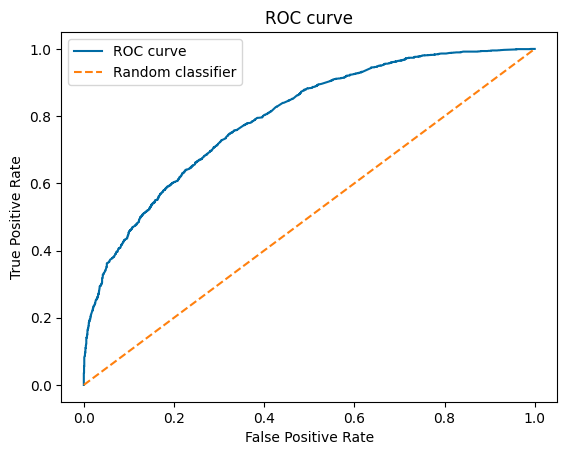

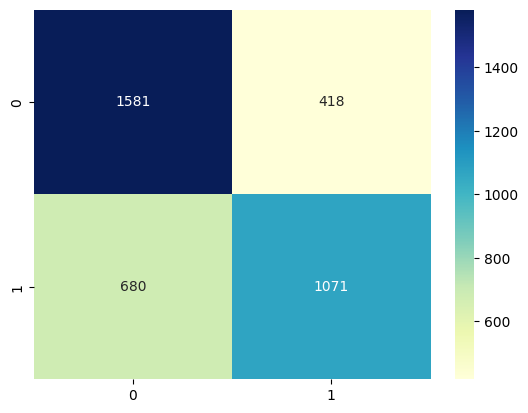

In [48]:
### SHOW EVALUATION METRICS FOR TRAIN DATA ###

print_plot_all_evaluation_metrics(y_train, y_train_pred, y_train_pred_proba)

---------------------------------------------------------------------------
Confusion Matrix: 
 [[497 169]
 [244 340]]
---------------------------------------------------------------------------
Accuracy : 
 66.96
---------------------------------------------------------------------------
Report : 
               precision    recall  f1-score   support

       False       0.67      0.75      0.71       666
        True       0.67      0.58      0.62       584

    accuracy                           0.67      1250
   macro avg       0.67      0.66      0.66      1250
weighted avg       0.67      0.67      0.67      1250

---------------------------------------------------------------------------
ROC-AUC: 
 0.7350055534987042


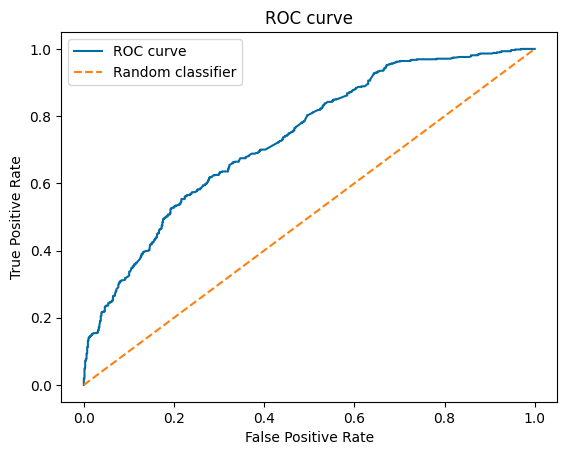

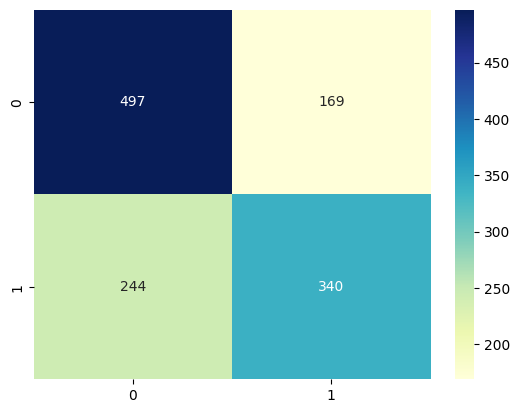

In [49]:
### SHOW EVALUATION METRICS FOR TEST DATA ###

print_plot_all_evaluation_metrics(y_test, y_test_pred, y_test_pred_proba)

In [46]:
# sns.barplot(x=X_train.columns, y=xg_boost_model.feature_importances_).set(title= "Influence of the Features on the XGBoost Model");

# show feature importance as list
feature_importance = pd.DataFrame(
    {"feature": X_train.columns, "importance": xg_boost_model.feature_importances_}
)

print(feature_importance.sort_values(by="importance", ascending=False))

                feature  importance
2            dojo_class    0.353879
4            sex_Female    0.207242
10        lang_Japanese    0.064888
6          lang_English    0.057310
3             test_prep    0.040470
0                   age    0.035804
1         hours_studied    0.034447
17       country_Mexico    0.030112
8           lang_French    0.026182
9          lang_Italian    0.025086
11         lang_Spanish    0.024626
21          country_USA    0.021372
12    country_Australia    0.016986
20           country_UK    0.016100
7          lang_Finnish    0.016070
19        country_Spain    0.015261
18  country_New Zealand    0.014166
13      country_Finland    0.000000
14       country_France    0.000000
15        country_Italy    0.000000
16        country_Japan    0.000000
5              sex_Male    0.000000


In [50]:
### FINDINGS ###

# as mentioned before, the model is using lang_Japanese as the most important feature: because the data is highly towards japan
# dojo_class is the most important feature: because it is helping the students to pass the test

# the model is not overfitting, because the train and test results are close to each other
# the confunsion matrix, the FP and FN are equally bad for the students

## Part 3: Reporting

In [56]:
# Calculate accuracy scores
train_accuracy = accuracy_score(y_train, xg_boost_model.predict(X_train))
test_accuracy = accuracy_score(y_test, y_test_pred)

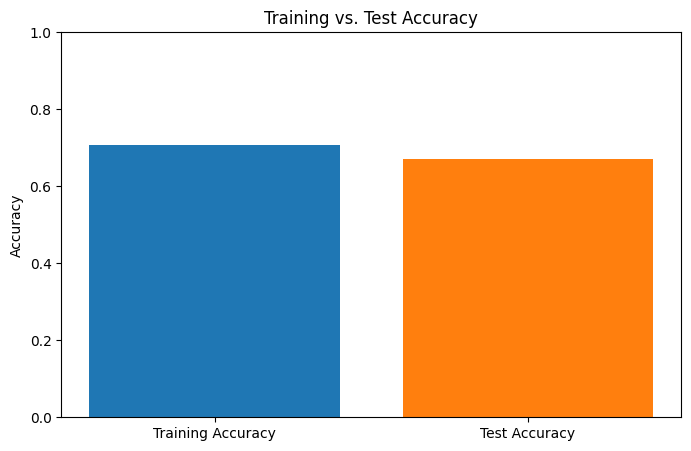

Training Accuracy:  0.7072
Test Accuracy:  0.6696


In [63]:
# show accuracy scores
accuracy_scores = [train_accuracy, test_accuracy]

# Create a bar chart to visualize the accuracy scores
labels = ["Training Accuracy", "Test Accuracy"]
accuracy_scores = [train_accuracy, test_accuracy]

colors = ["#1f77b4", "#ff7f0e"]

plt.figure(figsize=(8, 5))
plt.bar(labels, accuracy_scores, color=colors)
plt.title("Training vs. Test Accuracy")
plt.ylim(0, 1)  # Set the y-axis limit between 0 and 1
plt.ylabel("Accuracy")
plt.show()

print("Training Accuracy: ", train_accuracy)
print("Test Accuracy: ", test_accuracy)

### Ideas for how we might help more people pass the test and create more accurate models based on your findings:

Pass the test:
* To pass the test, do pair learning who already passed the test
* Provide additional resources, tutorials, or support to help students better prepare for the test. Understand the specific challenges students face and tailor support accordingly

How to make the model predict better:
* Use scaling for the data, like MinMax Scaler
* Create a new feature out of the features, that are already there
* Hyperparameter Tuning
* Do Error Analyses for the FP and FN, means dive deeper into Error Distribution of the features
* Try a different metric


In [ ]:
### AUTO ML ###

# I would use auto ml to find the best model for this data

In [ ]:
from tpot import TPOTClassifier

# Create and configure the TPOTClassifier
tpot = TPOTClassifier(
    generations=15,  # Number of iterations to run the optimization process
    population_size=50,  # Number of pipelines to consider in each generation
    verbosity=2,  # Show progress and logging
    random_state=42,  # Set a random seed for reproducibility
    scoring="accuracy",  # Choose an evaluation metric (e.g., accuracy, f1, roc_auc)
    n_jobs=-1,  # Use all available CPU cores for optimization
    cv=5,  # Use cross-validation
    early_stop=7,  # Early Stopping
)

# Fit TPOT to the training data
tpot.fit(X_train, y_train)

# Print the models considered by TPOT
for model_index, model in enumerate(tpot.evaluated_individuals_):
    print(f"Model {model_index + 1}: {model}")

# Evaluate the best pipeline on the test data
result = tpot.score(X_test, y_test)
print(f"Result: {result:.2f}")

# Export the best pipeline as Python code
tpot.export("best_model_pipeline.py")

# show the best model
print(f"Best model : {tpot.fitted_pipeline_}")